<a href="https://colab.research.google.com/github/kush1781/Titanic-Dataset-Exploration-and-Prediction/blob/master/Titanic_Dataset_Exploration_and_Prediction_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install catboost

     |████████████████████████████████| 64.7MB 56kB/s 


In [0]:
# general libraries
import math, time, random, datetime

# data manipulation libraries
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import GridSearchCV

# Machine learning Algos
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import catboost
from catboost import CatBoostClassifier, Pool, cv


# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [9]:
!wget 'https://raw.githubusercontent.com/kush1781/Titanic-Dataset-Exploration-and-Prediction/master/train.csv'
!wget 'https://raw.githubusercontent.com/kush1781/Titanic-Dataset-Exploration-and-Prediction/master/test.csv'
!wget 'https://raw.githubusercontent.com/kush1781/Titanic-Dataset-Exploration-and-Prediction/master/gender_submission.csv'

--2020-05-22 18:06:19--  https://raw.githubusercontent.com/kush1781/Titanic-Dataset-Exploration-and-Prediction/master/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  59.76K  --.-KB/s    in 0.03s   

2020-05-22 18:06:20 (2.19 MB/s) - ‘train.csv’ saved [61194/61194]

--2020-05-22 18:06:23--  https://raw.githubusercontent.com/kush1781/Titanic-Dataset-Exploration-and-Prediction/master/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

### Importing the data 

In [0]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
gender_submission = pd.read_csv('/content/gender_submission.csv')

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [13]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [0]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Type of data

### The missing values

In [0]:
# counting the missing values
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

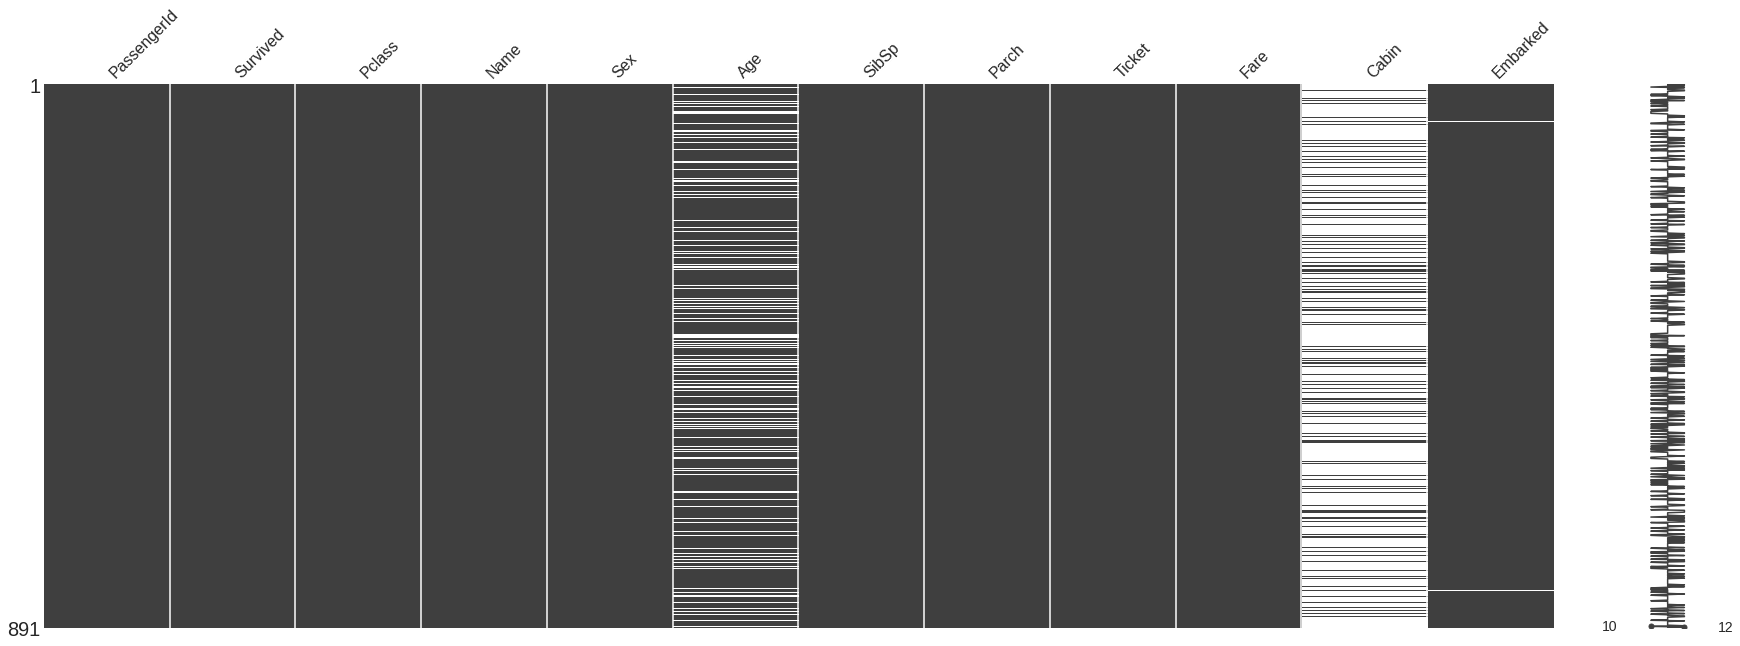

In [0]:
# visualizing the missing values
missingno.matrix(train, figsize = (30,10))

### Now to perform our data analysis we will create two DataFrames

In [0]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

### Function to create count and distribution visualisations

In [0]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False , use_count=True):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        if use_count:
            plt.subplot(1, 2, 1)
            sns.countplot(y=target_column, data=bin_df);
            plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived",'bw':0.1});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive",'bw':0.1});
    else:
        fig = plt.figure(figsize=figsize)
        if use_count:
            plt.subplot(1, 2, 1)
            sns.countplot(y=target_column, data=data);
            plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived",'bw':0.1});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive",'bw':0.1});

## Feature Selection and Feature Engineering

### Feature: PassengerId

Description: Unique ID of the passengers travelling on the ship.

We will ignore this feature as it is of our no use for our prediction

In [0]:
train['PassengerId'].head()

0    1
1    2
2    3
3    4
4    5
Name: PassengerId, dtype: int64

### Feature: Survived 

It is our target variable, lets explore it.

Description: Whether the passenger survived or not.
    
Key: 0 = did not survive, 1 = survived

0    549
1    342
Name: Survived, dtype: int64


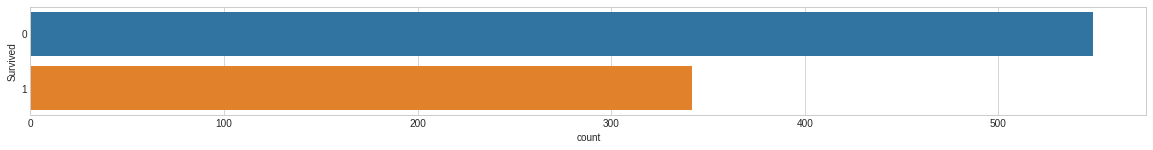

In [0]:
# how many survived, lets visualize it with count plot
fig = plt.figure(figsize=(20,2))
sns.countplot(y='Survived',data=train)
print(train.Survived.value_counts())

In [0]:
# lets add it to our dfs
df_con['Survived']=train['Survived']
df_bin['Survived']=train['Survived']

### Feature: Pclass

Description: The ticket class of the passenger.
    
Key: 1 = 1st, 2 = 2nd, 3 = 3rd

3    491
1    216
2    184
Name: Pclass, dtype: int64


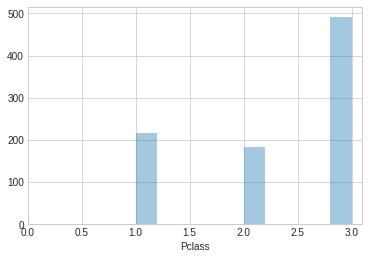

In [0]:
# lets visualize it by distplot
sns.distplot(train.Pclass,kde=False)
plt.xlim(xmin=0)
print(train.Pclass.value_counts())

In [0]:
# How many missing variables does Pclass have?
train.Pclass.isnull().sum()

0

In [0]:
# lets add it to our dfs
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

### Feature: Name

Description: Name of the passengers 

In [0]:
# checking if missing values
train.Name.isna().sum()

0

In [0]:
# How many different names are there?
train.Name.value_counts()

Lefebre, Miss. Ida                             1
Plotcharsky, Mr. Vasil                         1
Frolicher, Miss. Hedwig Margaritha             1
Sdycoff, Mr. Todor                             1
Berglund, Mr. Karl Ivar Sven                   1
                                              ..
Williams, Mr. Leslie                           1
Renouf, Mrs. Peter Henry (Lillian Jefferys)    1
Todoroff, Mr. Lalio                            1
Sage, Mr. Douglas Bullen                       1
Samaan, Mr. Youssef                            1
Name: Name, Length: 891, dtype: int64

In [0]:
train.Name.nunique()

891

As all the names are unique, thus we can't do something with them directly.

But what we can do is create a new feature by extracting their Titles or their Last Names

Lets see what we can do:

1) By their Titles

2) By their Last Names 

In [0]:
k=train.Name.str.split()
k

0                           [Braund,, Mr., Owen, Harris]
1      [Cumings,, Mrs., John, Bradley, (Florence, Bri...
2                             [Heikkinen,, Miss., Laina]
3      [Futrelle,, Mrs., Jacques, Heath, (Lily, May, ...
4                          [Allen,, Mr., William, Henry]
                             ...                        
886                            [Montvila,, Rev., Juozas]
887                    [Graham,, Miss., Margaret, Edith]
888       [Johnston,, Miss., Catherine, Helen, "Carrie"]
889                           [Behr,, Mr., Karl, Howell]
890                              [Dooley,, Mr., Patrick]
Name: Name, Length: 891, dtype: object

In [0]:
t=[]
ln=[]
for i in k:
    t.append(i[1])
    ln.append(i[0])

#### Lets explore Titles now

In [0]:
titles=pd.Series(t)
titles.head()

0      Mr.
1     Mrs.
2    Miss.
3     Mrs.
4      Mr.
dtype: object

In [0]:
titles.value_counts()

Mr.             502
Miss.           179
Mrs.            121
Master.          40
Dr.               7
Rev.              6
y                 4
Impe,             3
Planke,           3
Mlle.             2
Major.            2
Col.              2
Gordon,           2
Mulder,           1
Ms.               1
the               1
Pelsmaeker,       1
Don.              1
Walle,            1
Steen,            1
Melkebeke,        1
der               1
Carlo,            1
Shawah,           1
Mme.              1
Velde,            1
Messemaeker,      1
Billiard,         1
Cruyssen,         1
Capt.             1
Jonkheer.         1
dtype: int64

#### So here we will keep the first 4 categories and rest we will make them as Others

In [0]:
for i in range(891):
    if not(titles[i] in ['Mr.','Miss.','Mrs.','Master.']):
        titles[i]='Others.'
titles.value_counts()

Mr.        502
Miss.      179
Mrs.       121
Others.     49
Master.     40
dtype: int64

#### Lets explore Last Names now

In [0]:
last_names=pd.Series(ln)
last_names.head()

0       Braund,
1      Cumings,
2    Heikkinen,
3     Futrelle,
4        Allen,
dtype: object

In [0]:
last_names.value_counts()

Andersson,    9
Sage,         7
Johnson,      6
Skoog,        6
Carter,       6
             ..
Davis,        1
Bystrom,      1
Hood,         1
Hodges,       1
Razi,         1
Length: 661, dtype: int64

In [0]:
last_names.nunique()

661

#### As we see there are many uniques values so we will ignore the Last Names

In [0]:
# lets add it to our dfs
df_bin['Titles'] = titles
df_con['Titles'] = titles

### Feature: Sex

Description: The sex of the passenger (male or female).

male      577
female    314
Name: Sex, dtype: int64


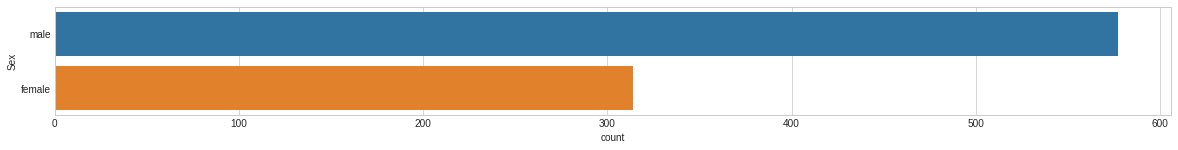

In [0]:
# Let's view the distribution of Sex
plt.figure(figsize=(20, 2))
sns.countplot(y="Sex", data=train)
print(train.Sex.value_counts())

In [0]:
train.Sex.isna().sum()

0

In [0]:
# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female
df_con['Sex'] = train['Sex']

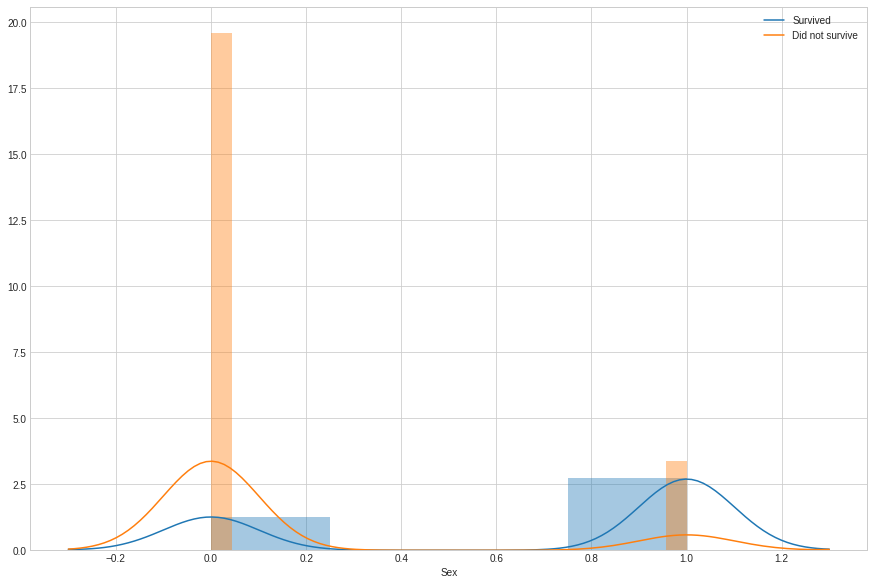

In [0]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
# Visualise the counts of Sex and the distribution of the values
# against Survived
plot_count_dist(df_bin, 
               bin_df=df_bin,
                label_column='Survived', 
                target_column='Sex', 
                figsize=(15, 10),
               use_bin_df=True,
               use_count=False)

#### from above we can see that not many people survived. But of those who did, more were female.

### Feature: Age

Description: The age of the passenger.

In [0]:
# How many missing values does age have?
train.Age.isnull().sum()

177

Out of a total 891 rows, that's almost one quarter of the dataset.

What would we do with these missing values?

Could replace them with the average age? What's the pro's and con's of doing this?

Or we can get rid of them completely? But that can affect our prediction as we will be loosing a lot of data

In [0]:
train.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

In [0]:
train.Age.mean()

29.69911764705882

In [0]:
train.Age.median()

28.0

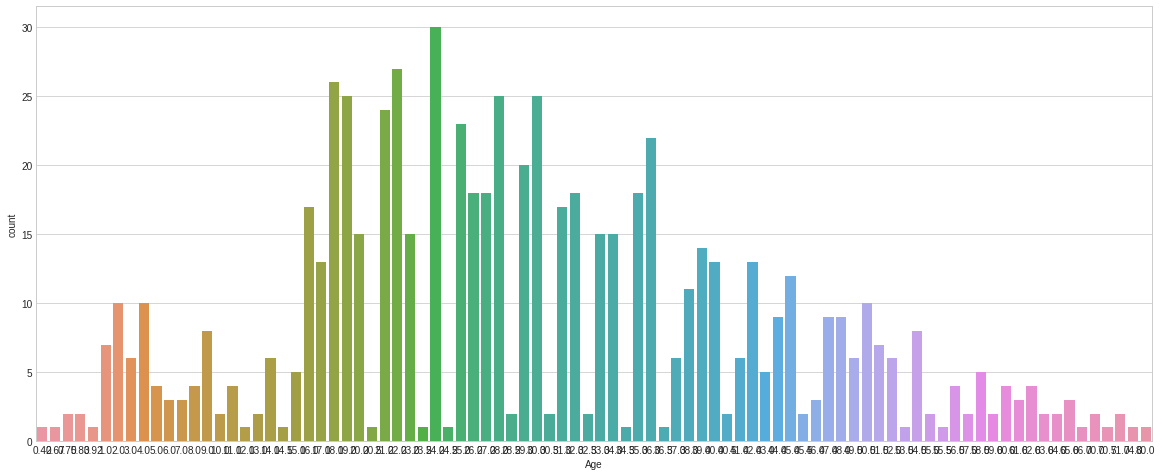

In [0]:
# age countplot
fig = plt.figure(figsize=(20,8))
sns.countplot(x='Age',data=train)

#### Lets try to discretize the age into: 

1) 0 - 20         as 1

2) 21 - 60        as 2

3) 61 - 100       as 3

4) null           as 0

In [0]:
a=[]
for i in train.Age:
    if np.isnan(i):
        a.append(0)
    elif i<21:
        a.append(1)
    elif i<61:
        a.append(2)
    else:
        a.append(3)

In [0]:
discrete_age=pd.DataFrame(a,columns=['Discrete_age'])
discrete_age.Discrete_age.value_counts()

2    512
1    180
0    177
3     22
Name: Discrete_age, dtype: int64

In [0]:
discrete_age = pd.concat([discrete_age,train.Survived,df_bin['Titles']],axis=1)

In [0]:
discrete_age.head()

,Discrete_age,Survived,Titles
0,2,0,Mr.
1,2,1,Mrs.
2,2,1,Miss.
3,2,1,Mrs.
4,2,0,Mr.


#### Now lets see how the survival is distributed among the Discretized Age

#### For the NAN category 0

In [0]:
discrete_age.loc[discrete_age.Discrete_age==0].Survived.value_counts()

0    125
1     52
Name: Survived, dtype: int64

In [0]:
discrete_age.loc[discrete_age.Discrete_age==0].Titles.value_counts()

Mr.        117
Miss.       36
Mrs.        17
Master.      4
Others.      3
Name: Titles, dtype: int64

In [0]:
discrete_age.loc[(discrete_age.Discrete_age==0) & (discrete_age.Survived==1)].Titles.value_counts()

Miss.      22
Mrs.       14
Mr.        13
Master.     2
Others.     1
Name: Titles, dtype: int64

#### For category 1

In [0]:
discrete_age.loc[discrete_age.Discrete_age==1].Survived.value_counts()

0    98
1    82
Name: Survived, dtype: int64

In [0]:
discrete_age.loc[discrete_age.Discrete_age==1].Titles.value_counts()

Miss.      66
Mr.        64
Master.    36
Mrs.        8
Others.     6
Name: Titles, dtype: int64

#### For category 2

In [0]:
discrete_age.loc[discrete_age.Discrete_age==2].Survived.value_counts()

0    309
1    203
Name: Survived, dtype: int64

In [0]:
discrete_age.loc[(discrete_age.Discrete_age==2)].Titles.value_counts()

Mr.        304
Mrs.        94
Miss.       76
Others.     38
Name: Titles, dtype: int64

#### For category 3 

In [0]:
discrete_age.loc[discrete_age.Discrete_age==3].Survived.value_counts()

0    17
1     5
Name: Survived, dtype: int64

In [0]:
discrete_age.loc[(discrete_age.Discrete_age==3)].Titles.value_counts()

Mr.        17
Mrs.        2
Others.     2
Miss.       1
Name: Titles, dtype: int64

#### So now we have seen that the Age with NaN values can be categoried with the help of their Titles

if Master or Miss then put in category 1
else in category 2

In [0]:
def func(x):
    if x in ['Master.','Miss.']:
         return 1
    else:
        return 2

In [0]:
df=discrete_age.loc[discrete_age.Discrete_age==0]
df.Discrete_age=df.Titles.apply(func)
discrete_age.loc[discrete_age.Discrete_age==0]=df

In [0]:
discrete_age.Discrete_age.value_counts()

2    649
1    220
3     22
Name: Discrete_age, dtype: int64

In [0]:
# adding this feature to our dfs
df_bin['Dis_age'] = discrete_age.Discrete_age
df_con['Dis_age'] = discrete_age.Discrete_age

### Feature: SibSp

Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [0]:
# How many missing values does SibSp have?
train.SibSp.isnull().sum()

0

In [0]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [0]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

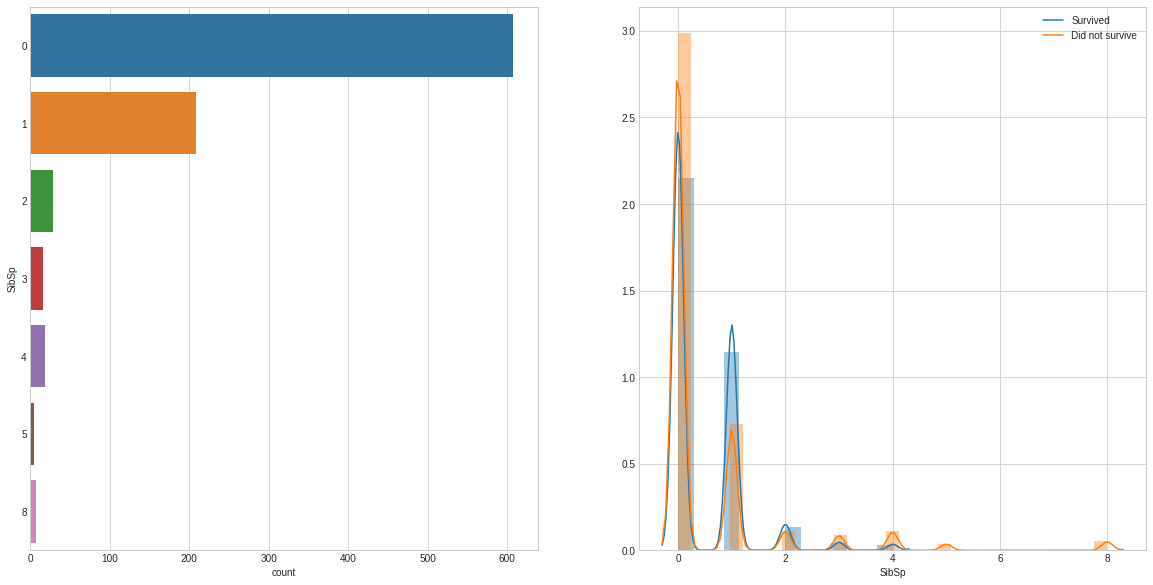

In [0]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

### Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

In [0]:
# How many missing values does Parch have?
train.Parch.isnull().sum()

0

In [0]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [0]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

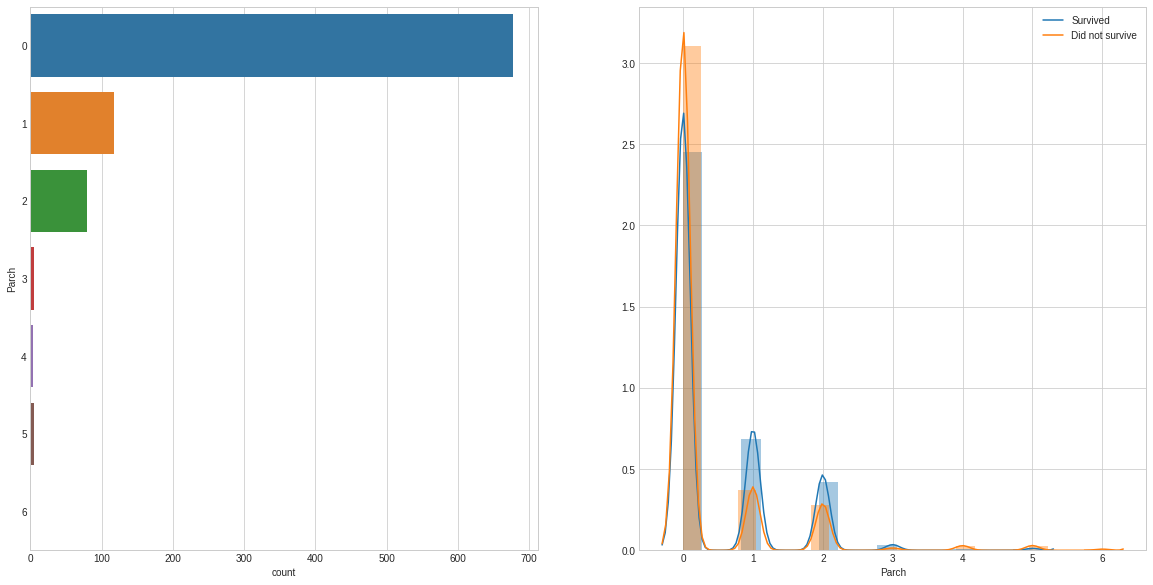

In [0]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train, 
               bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

#### From above two features' graph we can see that majority of the people who had 0 Parch or Sibsp survived

### Feature: Ticket

Description: The ticket number of the boarding passenger.

In [0]:
# How many missing values does Ticket have?
train.Ticket.isnull().sum()

0

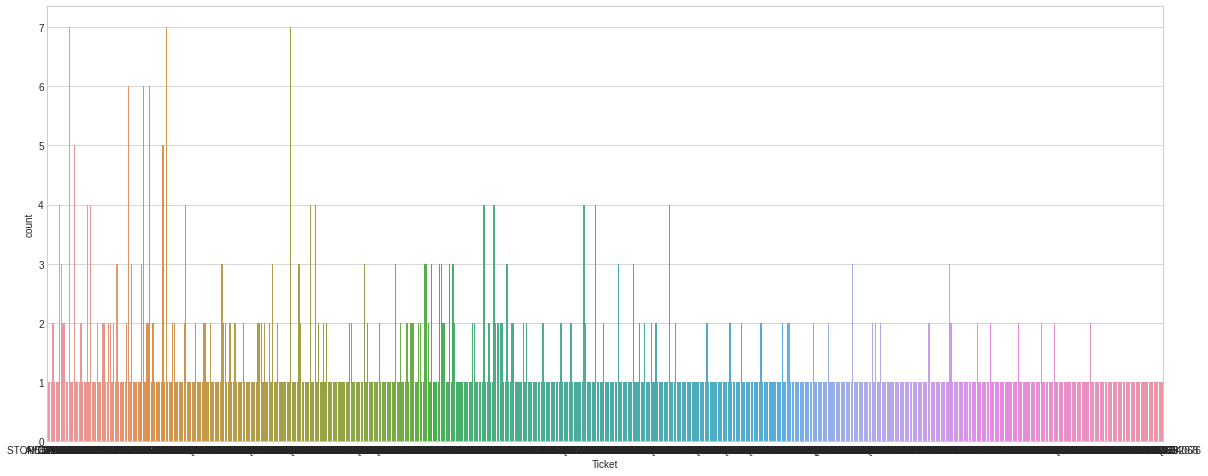

In [0]:
# How many kinds of ticket are there?
fig = plt.figure(figsize=(20,8))
sns.countplot(x="Ticket", data=train);

In [0]:
# How many kinds of ticket are there?
train.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
347088      6
3101295     6
           ..
234686      1
C 7076      1
370375      1
19952       1
13213       1
Name: Ticket, Length: 681, dtype: int64

In [0]:
# How many unique kinds of Ticket are there?
train.Ticket.nunique()

681

681 unique values is too many for now. So we won't use `Ticket` in our subset dataframes.

There may be some way to reduce this down. 

### Feature: Fare

Description: How much the ticket cost.

In [0]:
# How many missing values does Fare have?
train.Fare.isnull().sum()

0

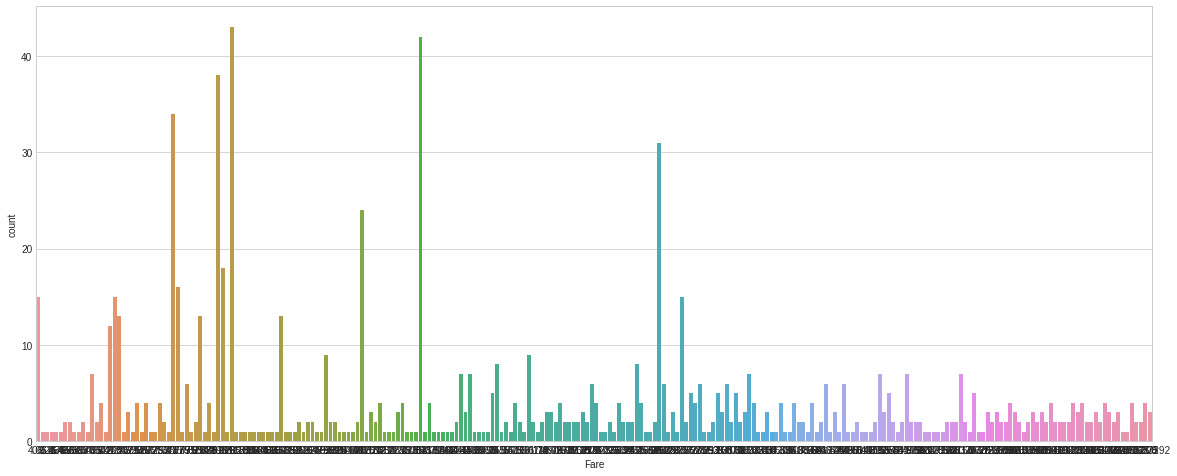

In [0]:
# How many different values of Fare are there?
fig = plt.figure(figsize=(20,8))
sns.countplot(x="Fare", data=train)

In [0]:
# How many kinds of Fare are there?
train.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

In [0]:
# How many unique kinds of Fare are there?
train.Fare.nunique()

248

#### Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.

In [0]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised 

In [0]:
# What do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

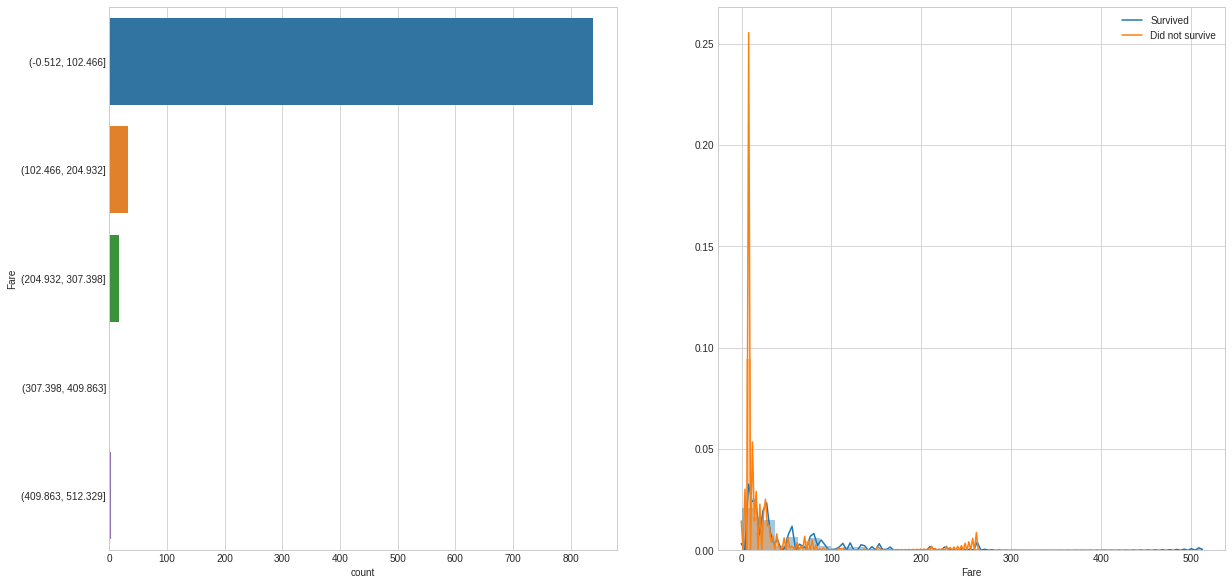

In [0]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

### Feature: Cabin

Description: The cabin number where the passenger was staying.    

In [0]:
# How many missing values does Cabin have?
train.Cabin.isnull().sum()

687

In [0]:
# What do the Cabin values look like?
train.Cabin.value_counts()

C23 C25 C27    4
B96 B98        4
G6             4
D              3
F33            3
              ..
D56            1
E40            1
C148           1
B3             1
C103           1
Name: Cabin, Length: 147, dtype: int64

#### Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.


### Feature: Embarked

Description: The port where the passenger boarded the Titanic.
    
Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [0]:
# How many missing values does Embarked have?
train.Embarked.isnull().sum()

2

In [0]:
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

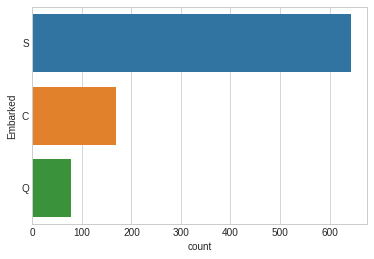

In [0]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train);

In [0]:
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [0]:
train[(train.Embarked=='S')&(train.Survived==1)].shape

(217, 12)

In [0]:
train[(train.Embarked=='S')&(train.Survived==0)].shape

(427, 12)

In [0]:
train[(train.Embarked=='C')&(train.Survived==1)].shape

(93, 12)

In [0]:
train[(train.Embarked=='C')&(train.Survived==0)].shape

(75, 12)

In [0]:
train[(train.Embarked=='Q')&(train.Survived==1)].shape

(30, 12)

In [0]:
train[(train.Embarked=='Q')&(train.Survived==0)].shape

(47, 12)

In [0]:
# Add Parch to subset dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [0]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


## Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (`df_bin`) with one-hot encoding and our continuous dataframe (`df_con`) also with one-hot encoding .

In [0]:
df_bin.head()

,Survived,Pclass,Titles,Sex,Dis_age,SibSp,Parch,Fare,Embarked
0,0,3,Mr.,0,2,1,0,"(-0.512, 102.466]",S
1,1,1,Mrs.,1,2,1,0,"(-0.512, 102.466]",C
2,1,3,Miss.,1,2,0,0,"(-0.512, 102.466]",S
3,1,1,Mrs.,1,2,1,0,"(-0.512, 102.466]",S
4,0,3,Mr.,0,2,0,0,"(-0.512, 102.466]",S


In [0]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Titles_Master.,Titles_Miss.,Titles_Mr.,Titles_Mrs.,Titles_Others.,Sex_0,Sex_1,Dis_age_1,Dis_age_2,Dis_age_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [0]:
df_con.head()

,Survived,Pclass,Titles,Sex,Dis_age,SibSp,Parch,Fare,Embarked
0,0,3,Mr.,male,2,1,0,7.2500,S
1,1,1,Mrs.,female,2,1,0,71.2833,C
2,1,3,Miss.,female,2,0,0,7.9250,S
3,1,1,Mrs.,female,2,1,0,53.1000,S
4,0,3,Mr.,male,2,0,0,8.0500,S


In [0]:
# One hot encode the categorical columns
df_pclass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

df_titles_one_hot = pd.get_dummies(df_con['Titles'], 
                                   prefix='titles')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_age_one_hot = pd.get_dummies(df_con['Dis_age'], 
                                prefix='age')

df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

In [0]:
df_con_enc = pd.concat([df_con, 
                        df_pclass_one_hot,
                        df_titles_one_hot,
                        df_sex_one_hot,
                        df_age_one_hot,
                        df_embarked_one_hot 
                        ], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass','Titles', 'Sex', 'Dis_age','Embarked'], axis=1)

In [0]:
# Let's look at df_con_enc
df_con_enc.head()

,Survived,SibSp,Parch,Fare,pclass_1,pclass_2,pclass_3,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_Others.,sex_female,sex_male,age_1,age_2,age_3,embarked_C,embarked_Q,embarked_S
0,0,1,0,7.2500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1
1,1,1,0,71.2833,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1
3,1,1,0,53.1000,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1
4,0,0,0,8.0500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1


## Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

In [0]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [0]:
selected_df.head()

,Survived,SibSp,Parch,Fare,pclass_1,pclass_2,pclass_3,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_Others.,sex_female,sex_male,age_1,age_2,age_3,embarked_C,embarked_Q,embarked_S
0,0,1,0,7.2500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1
1,1,1,0,71.2833,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1
3,1,1,0,53.1000,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1
4,0,0,0,8.0500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1


In [0]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [0]:
# Shape of the data (without labels)
X_train.shape

(889, 19)

In [0]:
# Shape of the labels
y_train.shape

(889,)

### Define a function to fit machine learning algorithms
Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [0]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, params,X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    
    clf = GridSearchCV(algo,
                    params,
                    cv=cv,
                    return_train_score=False )

    clf.fit(X_train,y_train)
    
    return acc, clf.best_score_ , clf.best_params_, clf

### Logistic Regression

In [0]:
# Logistic Regression
start_time = time.time()

C=[0.1, 1 , 10, 20]
solver = ['lbfgs','liblinear']

params = dict(
                C=C,
                solver=solver,
             )

acc_log, acc_cv_log, best_para_log, log_reg = fit_ml_algo(LogisticRegression(),
                                                  params,
                                                  X_train, 
                                                  y_train, 
                                                  10)

log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print('Best Parameters: %s' % best_para_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))
warnings.filterwarnings('ignore')

Accuracy: 83.69
Accuracy CV 10-Fold: 0.8268003064351379
Best Parameters: {'C': 1, 'solver': 'liblinear'}
Running Time: 0:00:02.086673


### K-Nearest Neighbours

In [0]:
# k-Nearest Neighbours
start_time = time.time()

n_neighbors = [5,10,15, 20]

params = dict(
                n_neighbors=n_neighbors,
             )



acc_knn, acc_cv_knn, best_para_knn, knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  params,
                                                  X_train, 
                                                  y_train, 
                                                  10)

knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print('Best Parameters: %s' % best_para_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 85.49
Accuracy CV 10-Fold: 0.775076608784474
Best Parameters: {'n_neighbors': 5}
Running Time: 0:00:00.353300


### Gaussian Naive Bayes

In [0]:
# Gaussian Naive Bayes
start_time = time.time()

params = dict()

acc_gaussian, acc_cv_gaussian, best_para_gaussian, navie_bayes = fit_ml_algo(GaussianNB(), 
                                                                 params,
                                                                 X_train, 
                                                                 y_train, 
                                                                 10)

gaussian_time = (time.time() - start_time)

print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print('Best Parameters: %s' % best_para_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 80.65
Accuracy CV 10-Fold: 0.7997957099080695
Best Parameters: {}
Running Time: 0:00:00.041660


### Support Vector Machines (SVC)

In [0]:
# Support Vector Machine
start_time = time.time()

C=[1,10,20,50,60]

params = dict(
                C=C
             )

acc_svc, acc_cv_svc, best_para_svc, svc = fit_ml_algo(SVC(gamma='auto'),
                                                               params,
                                                               X_train, 
                                                               y_train, 
                                                               10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_svc)
print('Best Parameters: %s' % best_para_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 83.69
Accuracy CV 10-Fold: 0.8144535240040858
Best Parameters: {'C': 50}
Running Time: 0:00:02.107176


### Stochastic Gradient Descent

In [0]:
# Stochastic Gradient Descent
start_time = time.time()

alpha =[0.0001,0.001,0.1,1]

params = dict(
                alpha=alpha
            )

acc_sgd, acc_cv_sgd, best_para_sgd, sgd = fit_ml_algo(SGDClassifier(), 
                                                  params,
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print('Best Parameters: %s' % best_para_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 63.44
Accuracy CV 10-Fold: 0.7468718079673136
Best Parameters: {'alpha': 0.1}
Running Time: 0:00:00.275276


### Decision Tree Classifier

In [0]:
# Decision Tree Classifier
start_time = time.time()

max_depth = [5,10,20]

params = dict(max_depth=max_depth)

acc_dt, acc_cv_dt, best_para_dt, dt = fit_ml_algo(DecisionTreeClassifier(), 
                                              params,
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print('Best Parameters: %s' % best_para_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 93.93
Accuracy CV 10-Fold: 0.8211695607763023
Best Parameters: {'max_depth': 5}
Running Time: 0:00:00.139425


### Random Forest Classifier

In [0]:
# Random Forest Classifier
start_time = time.time()

n_estimators=[50,100]
max_depth = [5,10,20]

params = dict(max_depth=max_depth,n_estimators=n_estimators)

acc_rf, acc_cv_rf, best_para_rf, rf = fit_ml_algo(RandomForestClassifier(), 
                                              params,
                                              X_train, 
                                              y_train,
                                              10)

rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print('Best Parameters: %s' % best_para_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 93.93
Accuracy CV 10-Fold: 0.8335418794688458
Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Running Time: 0:00:07.382172


### Gradient Boost Trees

In [0]:
# Gradient Boosting Trees
start_time = time.time()

learning_rate=[0.01,2]
n_estimators=[100]

params = dict(learning_rate=learning_rate,n_estimators=n_estimators)

acc_gbt, acc_cv_gbt, best_para_gbt, gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                  params,
                                                  X_train, 
                                                  y_train,
                                                  10)

gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print('Best Parameters: %s' % best_para_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 89.43
Accuracy CV 10-Fold: 0.8290347293156282
Best Parameters: {'learning_rate': 0.01, 'n_estimators': 100}
Running Time: 0:00:02.535433


### CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use. And is now regularly one of my go-to algorithms for any kind of machine learning task.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the [CatBoost docs](https://catboost.ai/).

In [0]:
# View the data for the CatBoost model
X_train.head()

,SibSp,Parch,Fare,pclass_1,pclass_2,pclass_3,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_Others.,sex_female,sex_male,age_1,age_2,age_3,embarked_C,embarked_Q,embarked_S
0,1,0,7.2500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1
1,1,0,71.2833,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1
3,1,0,53.1000,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1
4,0,0,8.0500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1


In [0]:
# Define the categorical features for the CatBoost model
cat_features = np.where((X_train.dtypes != np.float) )[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18])

In [0]:
# Cat Boost Trees
start_time = time.time()

learning_rate=[0.1]
iterations=[100]
depth=[5]

params = dict(learning_rate=learning_rate,iterations=iterations,depth=depth)

acc_cbt, acc_cv_cbt, best_para_cbt, cbt = fit_ml_algo(CatBoostClassifier(cat_features=cat_features), 
                                                  params,
                                                  X_train, 
                                                  y_train,
                                                  10)

cbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_cbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_cbt)
print('Best Parameters: %s' % best_para_cbt)
print("Running Time: %s" % datetime.timedelta(seconds=cbt_time))

Learning rate set to 0.009797
0:	learn: 0.6865009	total: 4.56ms	remaining: 4.56s
1:	learn: 0.6826009	total: 6.25ms	remaining: 3.12s
2:	learn: 0.6760721	total: 9.11ms	remaining: 3.03s
3:	learn: 0.6689518	total: 11.9ms	remaining: 2.96s
4:	learn: 0.6625093	total: 14.9ms	remaining: 2.96s
5:	learn: 0.6592312	total: 16.2ms	remaining: 2.68s
6:	learn: 0.6531639	total: 19.2ms	remaining: 2.72s
7:	learn: 0.6484440	total: 20.8ms	remaining: 2.58s
8:	learn: 0.6433293	total: 23.6ms	remaining: 2.59s
9:	learn: 0.6376588	total: 26.5ms	remaining: 2.62s
10:	learn: 0.6331552	total: 28ms	remaining: 2.52s
11:	learn: 0.6283123	total: 31.1ms	remaining: 2.56s
12:	learn: 0.6230815	total: 34.3ms	remaining: 2.6s
13:	learn: 0.6177940	total: 36.8ms	remaining: 2.59s
14:	learn: 0.6143878	total: 39.4ms	remaining: 2.59s
15:	learn: 0.6098071	total: 42ms	remaining: 2.58s
16:	learn: 0.6062735	total: 44.6ms	remaining: 2.58s
17:	learn: 0.6010687	total: 46.9ms	remaining: 2.56s
18:	learn: 0.5979686	total: 49.6ms	remaining: 2.5

In [0]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_cbt))
print("Running Time: {}".format(datetime.timedelta(seconds=cbt_time)))

---CatBoost Metrics---
Accuracy: 84.36
Accuracy cross-validation 10-Fold: 0.8324182839632277
Running Time: 0:00:04.544950


## Model Results
Which model had the best cross-validation accuracy?

**Note:** We care most about cross-validation metrics because the metrics we get from `.fit()` can randomly score higher than usual.

In [0]:
cv_models = pd.DataFrame({
    'Model': ['Logistic Regression',
              'KNN', 
              'Naive Bayes', 
              'SVC',
              'Stochastic Gradient Decent', 
              'Decision Tree',
              'Random Forest',
              'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_log,
         acc_cv_knn, 
        acc_cv_gaussian,
        acc_cv_svc,
        acc_cv_sgd, 
        acc_cv_dt,
        acc_cv_rf,
        acc_cv_gbt,
        acc_cv_cbt
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
6,Random Forest,0.833542
8,CatBoost,0.832418
7,Gradient Boosting Trees,0.829035
0,Logistic Regression,0.826800
5,Decision Tree,0.821170
3,SVC,0.814454
2,Naive Bayes,0.799796
1,KNN,0.775077
4,Stochastic Gradient Decent,0.746872


We can see from the tables, the CatBoost model had the best results. Getting just under 83% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the `.fit()` models as it does multiple passes over the data instead of one.

Because the CatBoost model got the best results, we'll use it for the next steps.

## Feature Importance
Which features of the best model were most important for making predictions?

In [0]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True,False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

In [0]:
# CatBoost model definition
catboost_model = CatBoostClassifier(cat_features=cat_features,
                                    learning_rate=0.1,
                                    iterations=100,
                                    depth=5)

# Fit CatBoost model
catboost_model.fit(train_pool,verbose=False)

,imp,col
15,0.335292,age_3
7,0.392289,titles_Miss.
9,0.433848,titles_Mrs.
17,0.536151,embarked_Q
13,0.651362,age_1
10,1.268068,titles_Others.
16,1.412099,embarked_C
18,1.434100,embarked_S
14,1.453870,age_2
1,2.685323,Parch


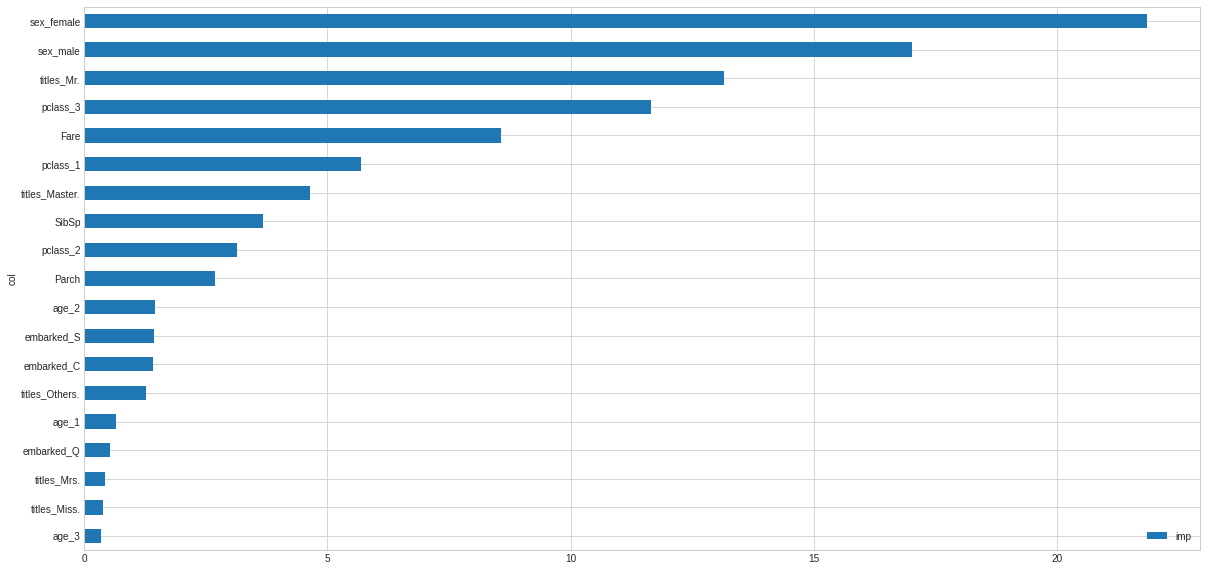

In [0]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

#### Why would you want feature importance?

Featrue importance shows how much each feature contributed to the model.

You could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

You could improve features which don't offer much to the overall model.

Or you could improve features which offer more to the model. In this case, there aren't many ways you could improve sex as it's already a binary.

Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

## Precision and Recall

Precision and recall are two metrics which are used for cases where you have have an imbalanced classification problem.

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

This is where precision an recall come in.

**Recall** = a metric which measures a models ability to find all the relevant cases in a dataset.

Recall would be the models ability to find the 1 person in 100,000 who has the disease.

**Precision** = a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an **F1 score.**

These metrics will all fall between 0 and 1, with a higher value being better.

Although, they don't necessarily need to come into play for our Titantic problem, they're worth remembering for your future work.


In [0]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

Precision: 0.8490966210696468
Recall: 0.7074999999999999
F1: 0.7716960321022494
AUC: 0.8847515536269154


Recall is low, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

Precision is higher therefore there's less false positives (predicting Survived, when it was actually Did not survive).


## Submission
Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the `test` dateframe, encode them and make a prediciton with our model.

In [0]:
# We need our test dataframe to look like this one
X_train.head()

,SibSp,Parch,Fare,pclass_1,pclass_2,pclass_3,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_Others.,sex_female,sex_male,age_1,age_2,age_3,embarked_C,embarked_Q,embarked_S
0,1,0,7.2500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1
1,1,0,71.2833,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1
3,1,0,53.1000,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1
4,0,0,8.0500,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1


In [0]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### We are going to add feature to our df_test and tackle all the feature like we had tackle in train dataset

In [0]:
df_test=pd.DataFrame()
df_test['Pclass']=test['Pclass']

In [0]:
k=test.Name.str.split()
t_test=[]
for i in k:
    t_test.append(i[1])
titles_test=pd.Series(t_test)
for i in range(len(titles_test)):
    if not(titles_test[i] in ['Mr.','Miss.','Mrs.','Master.']):
        titles_test[i]='Others.'
df_test['Titles']=titles_test

In [0]:
df_test['Sex']=test['Sex']

In [0]:
a=[]
for i in test.Age:
    if np.isnan(i):
        a.append(0)
    elif i<21:
        a.append(1)
    elif i<61:
        a.append(2)
    else:
        a.append(3)
discrete_age=pd.DataFrame(a,columns=['Discrete_age'])
discrete_age = pd.concat([discrete_age,df_test['Titles']],axis=1)

In [0]:
df=discrete_age.loc[discrete_age.Discrete_age==0]
df.Discrete_age=df.Titles.apply(func)
discrete_age.loc[discrete_age.Discrete_age==0]=df
df_test['Dis_age'] = discrete_age.Discrete_age

In [0]:
df_test['SibSp']=test['SibSp']
df_test['Parch']=test['Parch']

In [0]:
test.loc[test.Fare.isna(),'Fare']=10

In [0]:
df_test['Fare']=test['Fare']
df_test['Embarked']=test['Embarked']

In [0]:
df_test.head()

,Pclass,Titles,Sex,Dis_age,SibSp,Parch,Fare,Embarked
0,3,Mr.,male,2,0,0,7.8292,Q
1,3,Mrs.,female,2,1,0,7.0000,S
2,2,Mr.,male,3,0,0,9.6875,Q
3,3,Mr.,male,2,0,0,8.6625,S
4,3,Mrs.,female,2,1,1,12.2875,S


In [0]:
# One hot encode the categorical columns
df_pclass_one_hot = pd.get_dummies(df_test['Pclass'], 
                                   prefix='pclass')

df_titles_one_hot = pd.get_dummies(df_test['Titles'], 
                                   prefix='titles')

df_sex_one_hot = pd.get_dummies(df_test['Sex'], 
                                prefix='sex')

df_age_one_hot = pd.get_dummies(df_test['Dis_age'], 
                                prefix='age')

df_embarked_one_hot = pd.get_dummies(df_test['Embarked'], 
                                     prefix='embarked')


df_test_enc = pd.concat([df_test, 
                        df_pclass_one_hot,
                        df_titles_one_hot,
                        df_sex_one_hot,
                        df_age_one_hot,
                        df_embarked_one_hot 
                        ], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_test_enc = df_test_enc.drop(['Pclass','Titles', 'Sex', 'Dis_age','Embarked'], axis=1)

In [0]:
df_test_enc.head()

,SibSp,Parch,Fare,pclass_1,pclass_2,pclass_3,titles_Master.,titles_Miss.,titles_Mr.,titles_Mrs.,titles_Others.,sex_female,sex_male,age_1,age_2,age_3,embarked_C,embarked_Q,embarked_S
0,0,0,7.8292,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0
1,1,0,7.0000,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1
2,0,0,9.6875,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0
3,0,0,8.6625,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1
4,1,1,12.2875,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1


In [0]:
df_test_enc.shape

(418, 19)

In [0]:
# Make a prediction using the CatBoost model on df_test_enc
predictions = catboost_model.predict(df_test_enc)

In [0]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [0]:
# What does our submission have to look like?
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [0]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [0]:
# How does our submission dataframe look?
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [0]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [0]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('cat_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [0]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("cat_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
